# Semivariogram calculation - tutorial

## Table of Contents:

1. Read point data,
2. Set manually different semivariogram models,
3. Set automatically semivariogram model,
4. Export model,
5. Import model.

## Level: Basic

## Changelog

| Date | Change description | Author |
|------|--------------------|--------|
| 2021-05-28 | Updated paths for input/output data | @szymon-datalions |
| 2021-05-11 | Refactored TheoreticalSemivariogram class | @szymon-datalions |
| 2021-03-31 | Update related to the change of semivariogram weighting | @szymon-datalions |

## Introduction

In this tutorial we will learn how to read and prepare data for semivariogram modeling, how to manually set semivariogram type and how to do it automatically. We will compare different semivariogram models by visualizing outcomes of models.

Semivariogram modeling is an initial step before we can perform spatial interpolation of unknown values with Kriging. When you complete this tutorial you may learn how to:

- perform point Kriging (ordinary or simple),
- regularize semivariogram of areal data.

We use DEM data which is stored in a file `sample_data/point_data/poland_dem_gorzow_wielkopolski`.

## Import packages

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from pyinterpolate.io_ops import read_point_data
from pyinterpolate.semivariance import calculate_semivariance  # experimental semivariogram
from pyinterpolate.semivariance import TheoreticalSemivariogram  # theoretical models

## 1) Read point data

In [2]:
dem = read_point_data('../sample_data/point_data/poland_dem_gorzow_wielkopolski', data_type='txt')

In [3]:
# Look into a first few lines of data

dem[:10, :]

array([[15.1152409 , 52.76514556, 91.27559662],
       [15.1152409 , 52.74279035, 96.54829407],
       [15.1152409 , 52.71070647, 51.25455093],
       [15.1152409 , 52.70884354, 48.95828247],
       [15.1152409 , 52.67137785, 16.81786346],
       [15.1152409 , 52.6498506 , 16.29390526],
       [15.1152409 , 52.62770238, 16.54066277],
       [15.1152409 , 52.60596814, 19.45093346],
       [15.1152409 , 52.60493317, 19.24267578],
       [15.1152409 , 52.57823111, 45.66201019]])

## 2) Set manually different Semivariogram models

In [4]:
# Create experimental semivariogram

search_radius = 0.01
max_range = 0.39

exp_semivar = calculate_semivariance(data=dem, step_size=search_radius, max_range=max_range)

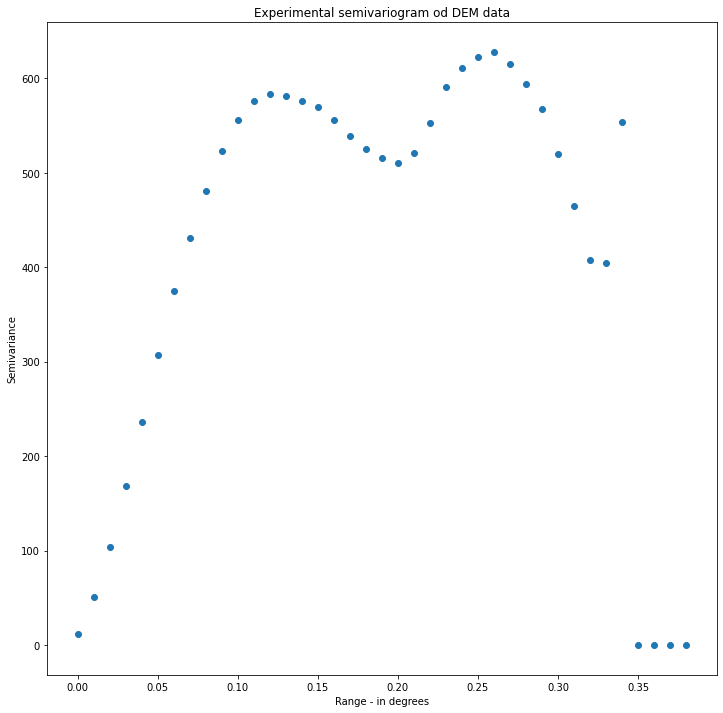

In [5]:
# Plot experimental semivariogram #1

plt.figure(figsize=(12, 12))
plt.plot(exp_semivar[:, 0], exp_semivar[:, 1], 'o')
plt.title('Experimental semivariogram od DEM data')
plt.xlabel('Range - in degrees')
plt.ylabel('Semivariance')
plt.show()

### Clarification:

We set search radius to 0.01 degree, this means that we gradually check semivariance of points at a distance 

**(r - search radius; r + search radius]**,

max_range variable describes upper limit of semivariogram searches, it is usually maximum distance in our points list. Figure of experimental semivariogram shows abrupt change at the distance of 0.35 degrees - we do not have points which are so far away. The better idea is to change max_range parameter to the 0.3 degree.

**Nugget** is slightly above 0. **Sill** is reached at approximately 600 points, and **range** of our model is about 0.12 degrees. 

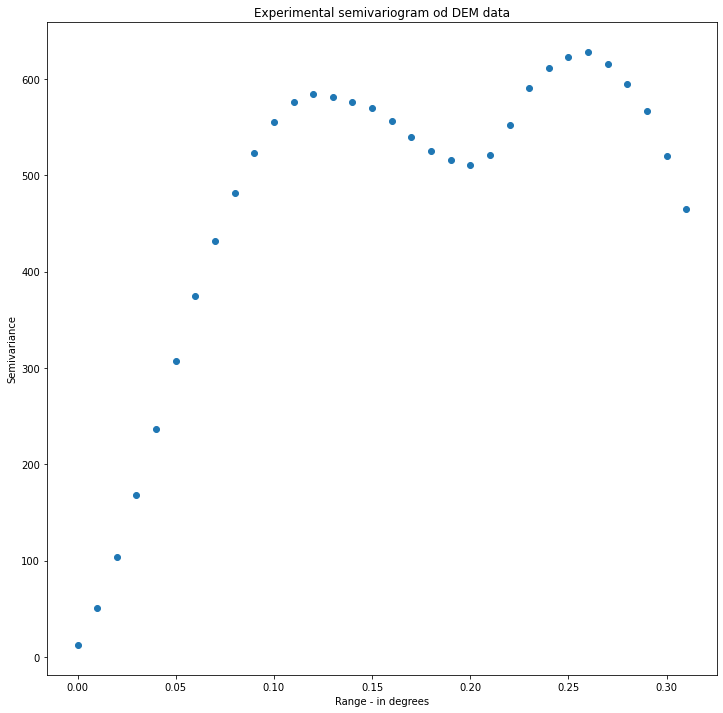

In [6]:
# Perform corrections

search_radius = 0.01
max_range = 0.32

exp_semivar = calculate_semivariance(data=dem, step_size=search_radius, max_range=max_range)

# Plot experimental semivariogram #2

plt.figure(figsize=(12, 12))
plt.plot(exp_semivar[:, 0], exp_semivar[:, 1], 'o')
plt.title('Experimental semivariogram od DEM data')
plt.xlabel('Range - in degrees')
plt.ylabel('Semivariance')
plt.show()

In [7]:
# Fit different semivariogram models into experimental data

baseline_model = TheoreticalSemivariogram(points_array=dem, empirical_semivariance=exp_semivar)
number_of_ranges = len(exp_semivar)  # The same number of ranges as experimental semivariogram

### Models:

* spherical,
* exponential,
* linear,
* gaussian

In [8]:
# Spherical

spherical_model = baseline_model.fit_semivariance(model_type='spherical', number_of_ranges=number_of_ranges)

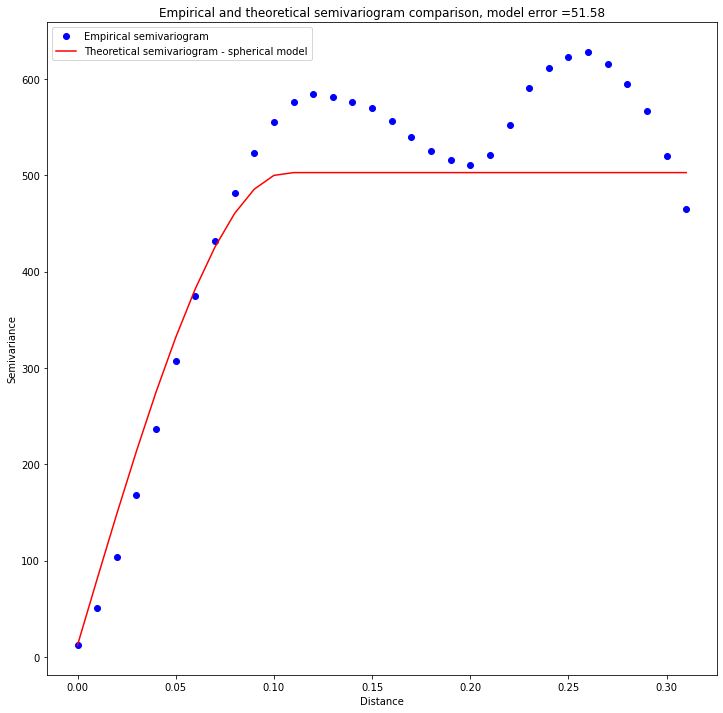

In [9]:
baseline_model.show_semivariogram()

In [10]:
baseline_model.model_error

51.581179602829174

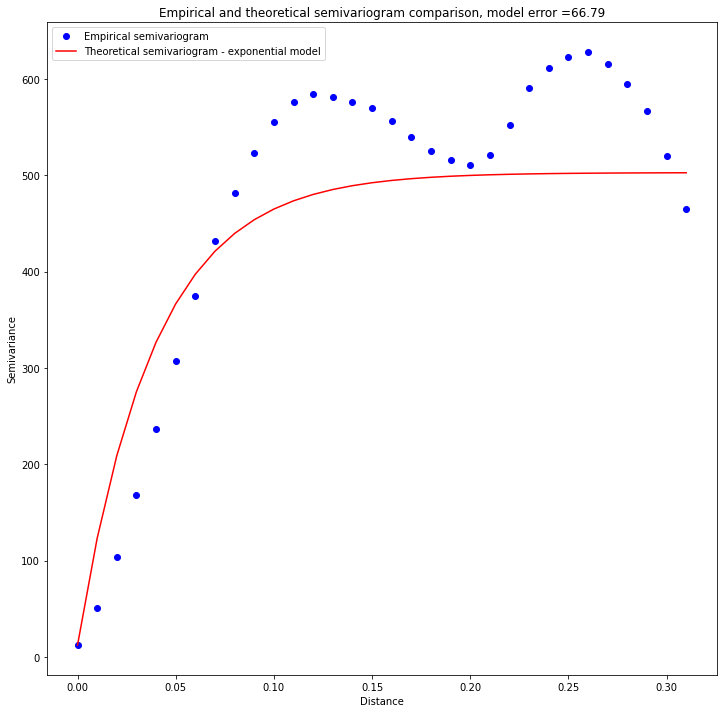

In [11]:
# Exponential

baseline_model.fit_semivariance(model_type='exponential', number_of_ranges=number_of_ranges)
baseline_model.show_semivariogram()

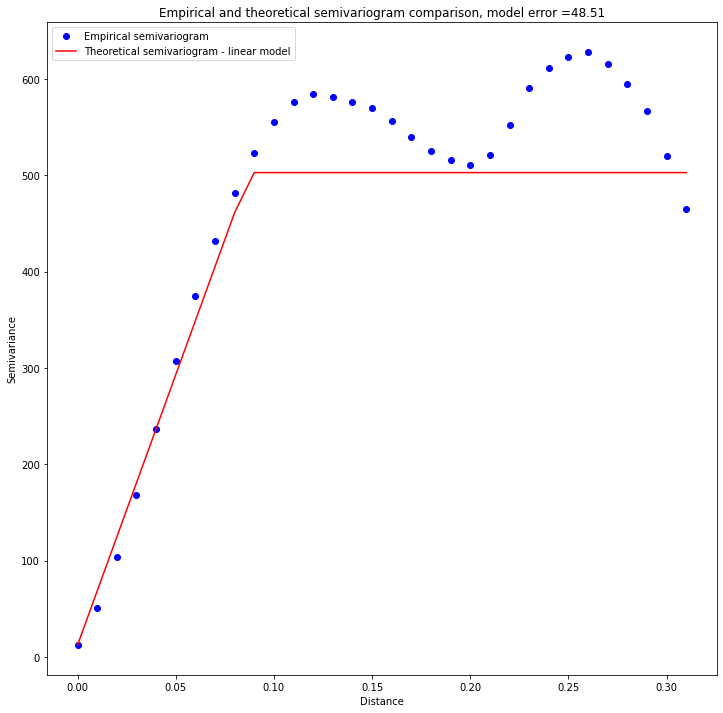

In [12]:
# Linear

baseline_model.fit_semivariance(model_type='linear', number_of_ranges=number_of_ranges)
baseline_model.show_semivariogram()

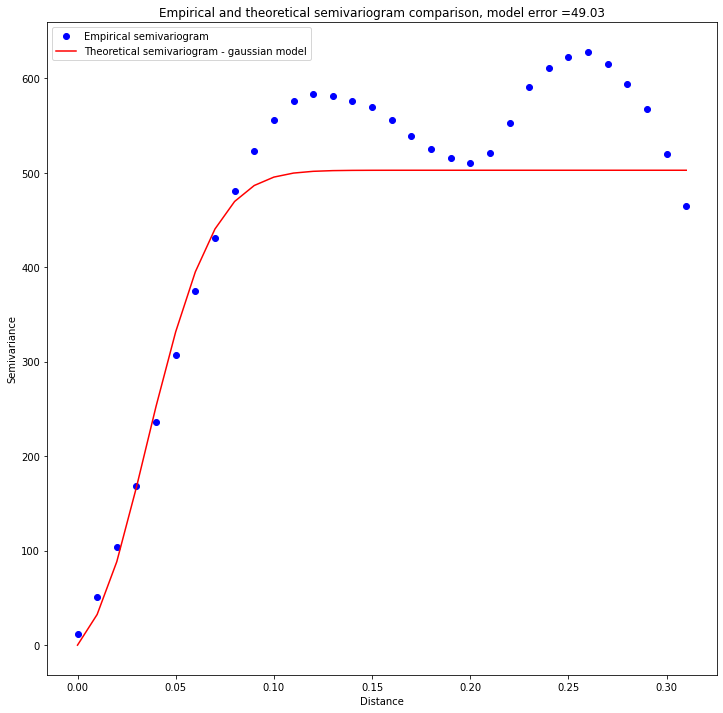

In [13]:
# Gaussian

baseline_model.fit_semivariance(model_type='gaussian', number_of_ranges=number_of_ranges)
baseline_model.show_semivariogram()

### Clarification:

We test four different semivariogram models. Each model gives different results, we can check model's mean absolute error of prediction by class instance **model_error** parameter or visualize it with **show_semivariogram()** method.

From comparison we see that the best models are linear and spherical. They could be used in further processing, especially if we know undergoing data process.

Manual selection of theoretical semivariogram model may be tedious. We can automate it with **find_optimal_model()** method. Let's try it and compare results to the manual selection.

## 3) Set automatically semivariogram model

In [14]:
best_choice = baseline_model.find_optimal_model(weighted=False, number_of_ranges=number_of_ranges)

### Clarification:

Chosen model is **linear** and it is automatically set as the class parameter. You may noticed that only spherical, exponential and linear models are considered in automatic searches. Why is that? Gaussian model (and in some cases exponential too) leads to the negative weights in a kriging model and possibly negative estimated value. You should be cautious with those two models and that's why Gaussian model was intentionally dropped from the automatic model search. (*Viable for version 0.2 of library*).

## 4) Export model

Models could be exported and used for other purposes. It is especially important for the **semivariogram regularization**. Those calculations are very slow and in a production it is not a good idea to build full piepline of semivariogram estimation and kriging; we divide it into two steps.

Model is saved into a csv file with class method **export_model()**. We pass into it a filename and we save name, nugget, sill and a range of a model.

In [15]:
# Set spherical model

baseline_model.fit_semivariance(model_type='linear', number_of_ranges=number_of_ranges)
baseline_model.export_model('output/semivariogram_calculation_model.csv')

## 5) Import model

We can import semivariogram model into a new **TheoreticalSemivariogram** class instance without passing into it experimental semivariogram or actual data points. It is useful for some applications where we are focused on kriging and we are sure that our semivariogram models fits data well.

Oposing to **export_model()** method we use **import_model()** method for it.

In [16]:
other_model = TheoreticalSemivariogram()

# import model parameters
other_model.import_model('output/semivariogram_calculation_model.csv')

In [17]:
print(f'Model nugget is {other_model.nugget}')
print(f'Model range is {other_model.range}')
print(f'Model sill is {other_model.sill}')

Model nugget is 12.244640305041026
Model range is 0.08741935483870968
Model sill is 490.4940934242805


In [18]:
other_model.chosen_model_name

'linear'

---